# Systems Dynamics:

Members: Viraj Kanchan, Nathan Mayer, Shubang Mukund, Matthew Nolan

Code Written by Nathan Mayer

Code Adapted from the Triple Pendulum Example, Solving Nonlinear Four-Bar Constraints, and Falling Rod Example Code Written by Professor Daniel Aukes

Triple Pendulum Example Code: https://foldable-robotics.github.io/modules/dynamics/generated/08-triple-pendulum-example/

## System Kinematics Figure:

<img src='https://drive.google.com/uc?id=1n8KlDhqv8kxqkUDIxMgCXLMRzwZ3RAF0' width="600">

##Paper Model:

<img src='https://drive.google.com/uc?id=1UjM9wa0ghvNNOO5JXU1Iy3jgVrLcS6f2' width="300">

<img src='https://drive.google.com/uc?id=1uYPlwpIFRbJQvaMWyjlJh5Tn5gu700NQ' width="300">

<img src='https://drive.google.com/uc?id=1t2fsh0MN521ZPTDzsgL6mwciavRxpNaM' width="300">



##Pynamics Script:

In [1]:
use_constraints = True

In [2]:
# Import all necessary packages:

!pip install pynamics
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint,KinematicConstraint
import pynamics.integration
import numpy
import sympy
import scipy.optimize
import matplotlib.pyplot as plt
plt.ion()
from math import pi

     |████████████████████████████████| 87 kB 4.5 MB/s 


In [3]:
# Define Initial System:

system = System()
pynamics.set_system(__name__,system)

### Parametrization:

Link lengths were based off the dimensions of the biological model. The proportions of the entire canine limb were altered to be approximately 130 mm tall with each link being 50 mm. The end effector was chosen to be slightly longer to allow for more deflection in that link. Therefore, the end effector was chosen to be about 80mm long.

Masses were calculated based on the mass of individual links made using the chosen materials. The mass would then be scaled based on the dimensions of the corrsponding link.

The mass of the rig was chosen based on the early model of the testing rig. Therefore, the pynamics model can account for the added weight of the rig once fully implented in the final prototype.

The moments of inertia were found by simulating each link as a flat plate and then calculating the moments in the x- and z- directions, while neglecting the y direction for this simulation. Each link was modeled with a standard width of 10 mm in the z-direction.

In [4]:
# Create constant values for length, mass, springs, inertia, etc.

lA1 = Constant(0.05,'lA1',system) # Meters
lB1 = Constant(0.05,'lB1',system) # Meters
lC1 = Constant(0.05,'lC1',system) # Meters
lA2 = Constant(0.05,'lA2',system) # Meters
lB2 = Constant(0.05,'lB2',system) # Meters
lA31 = Constant(0.08*2/3,'lA31',system) # Meters
lA32 = Constant(0.08*1/3,'lA32',system) # Meters
lRig = Constant(0.2,'lRig',system) # Meters

mA1 = Constant(0.006,'mA1',system)
mB1 = Constant(0.006,'mB1',system)
mC1 = Constant(0.006,'mC1',system)
mA2 = Constant(0.006,'mA2',system)
mB2 = Constant(0.006,'mB2',system)
mA31 = Constant(0.006,'mA31',system)
mA32 = Constant(0.0003,'A32',system)

m_end = Constant(0.05,'m_end',system)
mRig = Constant(0.2,'mRig',system)

g = Constant(9.81,'g',system) # acceleration due to gravity
b = Constant(1e-2,'b',system) # damping constant
k = Constant(1e-2,'k',system) # spring constant
k_ground = Constant(2e4,'k_ground',system) # ground spring constant
b_ground = Constant(8e5,'b_ground',system) # ground damping constant
k_endeffector = Constant(1e0,'k',system) # spring constant

# spring preloads
preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)
preload4 = Constant(0*pi/180,'preload4',system)
preload5 = Constant(0*pi/180,'preload5',system)
preload6 = Constant(0*pi/180,'preload6',system)
preload7 = Constant(0*pi/180,'preload7',system)

# link principal moments of inertia
Ixx_Rig = Constant(4.167*10**-9,'Ixx_Rig',system)
Iyy_Rig = Constant(1,'Iyy_Rig',system)
Izz_Rig = Constant(1.042*10**-7,'Izz_Rig',system)
Ixx_A1B1 = Constant(4.167*10**-9,'Ixx_A1B1',system)
Iyy_A1B1 = Constant(1,'Iyy_A1B1',system)
Izz_A1B1 = Constant(1.042*10**-7,'Izz_A1B1',system)
Ixx_B1C1 = Constant(4.167*10**-9,'Ixx_B1C1',system)
Iyy_B1C1 = Constant(1,'Iyy_B1C1',system)
Izz_B1C1 = Constant(1.042*10**-7,'Izz_B1C1',system)
Ixx_C1B2 = Constant(4.167*10**-9,'Ixx_C1B2',system)
Iyy_C1B2 = Constant(1,'Iyy_C1B2',system)
Izz_C1B2 = Constant(1.042*10**-7,'Izz_C1B2',system)
Ixx_A2B2 = Constant(4.167*10**-9,'Ixx_A2B2',system)
Iyy_A2B2 = Constant(1,'Iyy_A2B2',system)
Izz_A2B2 = Constant(1.042*10**-7,'Izz_A2B2',system)
Ixx_B2C1 = Constant(4.167*10**-9,'Ixx_B2C1',system)
Iyy_B2C1 = Constant(1,'Iyy_B2C1',system)
Izz_B2C1 = Constant(1.042*10**-7,'Izz_B2C1',system)
Ixx_C1A31 = Constant(4.444*10**-9,'Ixx_C1A31',system)
Iyy_C1A31 = Constant(1,'Iyy_C1A31',system)
Izz_C1A31 = Constant(1.264*10**-7,'Izz_C1A31',system)
Ixx_A31A32 = Constant(2.222*10**-9,'Ixx_A31A32',system)
Iyy_A31A32 = Constant(1,'Iyy_A31A32',system)
Izz_A31A32 = Constant(1.580*10**-7,'Izz_A31A32',system)


# input torques and frequencies
torque1 = Constant(0.4,'torque1',system)
torque2 = Constant(0.6,'torque2',system)

freq1 = Constant(0.2,'freq1',system)
freq2 = Constant(0.2,'freq2',system)

qA31 = Constant(0,'qA31',system)
qA1 = Constant(0,'qA1',system)
qOrigin = Constant(0,'qOrigin',system)

In [5]:
# Differentiable State Variables:

qRig,qRig_d,qRig_dd = Differentiable('qRig',system)
qB1,qB1_d,qB1_dd = Differentiable('qB1',system)
qC1,qC1_d,qC1_dd = Differentiable('qC1',system)
qA2,qA2_d,qA2_dd = Differentiable('qA2',system)
qB2,qB2_d,qB2_dd = Differentiable('qB2',system)
qA32,qA32_d,qA32_dd = Differentiable('qA32',system)
lOrigin,lOrigin_d,lOrigin_dd = Differentiable('lOrigin',system)

In [6]:
# Initial Values:

initialvalues = {}
initialvalues[qRig]=(0)*pi/180
initialvalues[qRig_d]=0*pi/180
initialvalues[qB1]=(-100)*pi/180
initialvalues[qB1_d]=0*pi/180
initialvalues[qC1]=(-50)*pi/180
initialvalues[qC1_d]=0*pi/180
initialvalues[qA2]=(-140)*pi/180
initialvalues[qA2_d]=0*pi/180
initialvalues[qB2]=(80)*pi/180
initialvalues[qB2_d]=0*pi/180
initialvalues[qA32]=(0)*pi/180
initialvalues[qA32_d]=0*pi/180
initialvalues[lOrigin]=0
initialvalues[lOrigin_d]=0

In [7]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

### Kinematics:

In [8]:
# Define All Frames:

Origin = Frame('O',system)
O = Frame('O',system)
Rig = Frame('Rig',system)
A1 = Frame('A1',system)
B1 = Frame('B1',system)
C1 = Frame('C1',system)
A2 = Frame('A2',system)
B2 = Frame('B2',system)
A31 = Frame('A31',system)
A32 = Frame('A32',system)

In [9]:
# Define Newtonian Frame:

system.set_newtonian(Origin)

In [10]:
# Define Frame Rotations:

O.rotate_fixed_axis(Origin,[0,0,1],qOrigin,system)
Rig.rotate_fixed_axis(O,[0,0,1],qRig,system)
A1.rotate_fixed_axis(Rig,[0,0,1],qA1,system)
B1.rotate_fixed_axis(A1,[0,0,1],qB1,system)
C1.rotate_fixed_axis(B1,[0,0,1],qC1,system)
A2.rotate_fixed_axis(Rig,[0,0,1],qA2,system)
B2.rotate_fixed_axis(A2,[0,0,1],qB2,system)
A31.rotate_fixed_axis(B2,[0,0,1],qA31,system)
A32.rotate_fixed_axis(A31,[0,0,1],qA32,system)

In [11]:
# Create Point Vectors based on Frame Rotations:

pOrigin = 0*Origin.x
pO = pOrigin + lOrigin*O.x
pORig = pO + lRig*Rig.x
pRigA1 = pORig + 0*A1.x
pA1B1 = pRigA1 + lA1*A1.x
pB1C1 = pA1B1 + lB1*B1.x
pC1B2 = pB1C1 + lC1*C1.x

pRigA2 = pORig + 0*A2.x
pA2B2 = pRigA2 + lA2*A2.x
pB2C1 = pA2B2 + lB2*B2.x

pC1A31 = pB2C1 + lA31*A31.x
pA31A32 = pC1A31 + lA32*A32.x

In [12]:
# Create Particle Entity to be Used in Ground Contact Force

Particle1 = Particle(pA31A32,m_end,'Particle1',system)
Particle2 = Particle(pA1B1,mRig,'Particle2',system)

In [13]:
# Create an array of points:

points = [pC1B2,pB1C1,pA1B1,pRigA1,pRigA2,pO,pRigA1,pRigA2,pA2B2,pB2C1,pC1A31,pA31A32]

p = numpy.array(points)
points

[lA1*A1.x + lB1*B1.x + lC1*C1.x + lRig*Rig.x + lOrigin*O.x,
 lA1*A1.x + lB1*B1.x + lRig*Rig.x + lOrigin*O.x,
 lA1*A1.x + lRig*Rig.x + lOrigin*O.x,
 lRig*Rig.x + lOrigin*O.x,
 lRig*Rig.x + lOrigin*O.x,
 lOrigin*O.x,
 lRig*Rig.x + lOrigin*O.x,
 lRig*Rig.x + lOrigin*O.x,
 lA2*A2.x + lRig*Rig.x + lOrigin*O.x,
 lA2*A2.x + lB2*B2.x + lRig*Rig.x + lOrigin*O.x,
 lA2*A2.x + lA31*A31.x + lB2*B2.x + lRig*Rig.x + lOrigin*O.x,
 lA2*A2.x + lA31*A31.x + lA32*A32.x + lB2*B2.x + lRig*Rig.x + lOrigin*O.x]

In [14]:
# Plot Estimated System Position:

l = len(p)

state1 = initialvalues


px = []
for i in range(0,l):
    q = p[i]
    x = q.dot(O.x)
    px.append(x)

px1 = [item.subs(state1) for item in px]
px1 = [item.subs(system.constant_values) for item in px1]
print('px1: ')
print(px1)

py = []
for i in range(0,l):
    q = p[i]
    y = q.dot(O.y)
    py.append(y)

py1 = [item.subs(state1) for item in py]
py1 = [item.subs(system.constant_values) for item in py1]
print('py1: ')
print(py1)

pz = []
for i in range(0,l):
    q = p[i]
    z = q.dot(O.z)
    pz.append(z)

pz1 = [item.subs(state1) for item in pz]
pz1 = [item.subs(system.constant_values) for item in pz1]
print('pz1: ')
print(pz1)

px1: 
[0.198016320927432, 0.241317591116653, 0.250000000000000, 0.200000000000000, 0.200000000000000, 0, 0.200000000000000, 0.200000000000000, 0.161697777844051, 0.186697777844051, 0.213364444510718, 0.226697777844051]
py1: 
[-0.0742403876506104, -0.0492403876506104, 0, 0, 0, 0, 0, 0, -0.0321393804843270, -0.0754406506735489, -0.121628672208719, -0.144722682976304]
pz1: 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


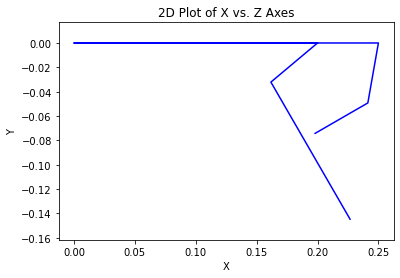

In [15]:
# 2D Plot (X vs. Z Axes)

plt.plot(px1[0:4],py1[0:4],'b')
plt.plot(px1[4:l],py1[4:l],'b')
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot of X vs. Z Axes');

### Solve for valid initial condition determined by independent variable:

In [16]:
# Setup Optimization Equations:

ini0 = [initialvalues[item] for item in statevariables]

eq_vector = [pB2C1-pC1B2] # Output Should be Zero when End Points from Each Segment are Subtracted

eq_scalar = []
eq_scalar.append((eq_vector[0]).dot(O.x))
eq_scalar.append((eq_vector[0]).dot(O.y))

eq_scalar

[lA1*sin(qA1)*sin(qRig) - lA1*cos(qA1)*cos(qRig) - lA2*sin(qA2)*sin(qRig) + lA2*cos(qA2)*cos(qRig) - lB1*(-sin(qA1)*sin(qRig) + cos(qA1)*cos(qRig))*cos(qB1) - lB1*(-sin(qA1)*cos(qRig) - sin(qRig)*cos(qA1))*sin(qB1) + lB2*(-sin(qA2)*sin(qRig) + cos(qA2)*cos(qRig))*cos(qB2) + lB2*(-sin(qA2)*cos(qRig) - sin(qRig)*cos(qA2))*sin(qB2) - lC1*(-sin(qA1)*sin(qRig) + cos(qA1)*cos(qRig))*(-sin(qB1)*sin(qC1) + cos(qB1)*cos(qC1)) - lC1*(-sin(qA1)*cos(qRig) - sin(qRig)*cos(qA1))*(sin(qB1)*cos(qC1) + sin(qC1)*cos(qB1)), -lA1*sin(qA1)*cos(qRig) - lA1*sin(qRig)*cos(qA1) + lA2*sin(qA2)*cos(qRig) + lA2*sin(qRig)*cos(qA2) - lB1*(-sin(qA1)*sin(qRig) + cos(qA1)*cos(qRig))*sin(qB1) - lB1*(sin(qA1)*cos(qRig) + sin(qRig)*cos(qA1))*cos(qB1) + lB2*(-sin(qA2)*sin(qRig) + cos(qA2)*cos(qRig))*sin(qB2) + lB2*(sin(qA2)*cos(qRig) + sin(qRig)*cos(qA2))*cos(qB2) - lC1*(-sin(qA1)*sin(qRig) + cos(qA1)*cos(qRig))*(sin(qB1)*cos(qC1) + sin(qC1)*cos(qB1)) - lC1*(sin(qA1)*cos(qRig) + sin(qRig)*cos(qA1))*(-sin(qB1)*sin(qC1) + c

In [17]:
# Define Independent and Dependent Variables

qi = [qA2,qB1]
qd = [qRig,qC1,qB2]

eq_scalar_c = [item.subs(system.constant_values) for item in eq_scalar]

defined = dict([(item,initialvalues[item]) for item in qi])
eq_scalar_c = [item.subs(defined) for item in eq_scalar_c]
eq_scalar_c

error = (numpy.array(eq_scalar_c)**2).sum()
print(error)

0.00633931466556407*(0.627984391633901*(-0.17364817766693*sin(qC1) - 0.984807753012208*cos(qC1))*sin(qRig) - 0.627984391633901*(0.984807753012208*sin(qC1) - 0.17364817766693*cos(qC1))*cos(qRig) + 0.627984391633901*(0.642787609686539*sin(qRig) - 0.766044443118978*cos(qRig))*cos(qB2) + 0.627984391633901*(0.766044443118978*sin(qRig) + 0.642787609686539*cos(qRig))*sin(qB2) - 0.21478331163291*sin(qRig) - cos(qRig))**2 + 0.00633931466556407*(-0.627984391633901*(-0.17364817766693*sin(qC1) - 0.984807753012208*cos(qC1))*cos(qRig) - 0.627984391633901*(0.984807753012208*sin(qC1) - 0.17364817766693*cos(qC1))*sin(qRig) + 0.627984391633901*(-0.766044443118978*sin(qRig) - 0.642787609686539*cos(qRig))*cos(qB2) + 0.627984391633901*(0.642787609686539*sin(qRig) - 0.766044443118978*cos(qRig))*sin(qB2) - sin(qRig) + 0.21478331163291*cos(qRig))**2


In [18]:
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [19]:
# Define Initial Guess and Use Optimize Equation to Find Actual Angles:

guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))

In [20]:
# Save New Points to Plot the Actual System Results:

ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

In [21]:
# Display Error from Optimization Equation:
result.fun

7.943263812780144e-10

2022-05-01 03:47:54,377 - pynamics.output - INFO - calculating outputs
2022-05-01 03:47:54,381 - pynamics.output - INFO - done calculating outputs


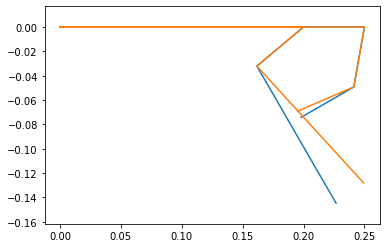

In [22]:
# Plot Calculated System (Orange) vs. Initial Guess (Blue)
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]),numpy.array([0,1]))
points.plot_time()

In [23]:
result.x

array([ 5.71851662e-10, -9.89244645e-01,  1.61299201e+00])

In [24]:
# Define a new State for Joint Angles based on Optimization Equation:

state2 = {}
state2[qRig] = result.x[0]
state2[qRig_d] = 0*pi/180
state2[qB1]= initialvalues[qB1]
state2[qB1_d] = 0*pi/180
state2[qC1] = result.x[1]
state2[qC1_d] = 0*pi/180
state2[qA2] = initialvalues[qA2]
state2[qA2_d] = 0*pi/180
state2[qB2] = result.x[2]
state2[qB2_d] = 0*pi/180

# Dynamics Simulation:

## Centers of Mass:

The centers of mass of each link are taken at the centers of their respective linear segments.

In [25]:
pORigcm = pO +lRig*O.x
pA1B1cm=pRigA1+lA1/2*A1.x
pB1C1cm=pA1B1+lB1/2*B1.x
pC1B2cm=pB1C1+lC1/2*C1.x
pA2B2cm=pRigA2+lA2/2*A2.x
pB2C1cm=pA2B2+lB2/2*B2.x
pC1A31cm=pC1A31+lA31/2*A31.x
pA31A32cm=pA31A32+lA32/2*A32.x

## Angular Velocity:

In [26]:
wORig = O.get_w_to(Rig)
wRigA1 = Rig.get_w_to(A1)
wA1B1 = A1.get_w_to(B1)
wB1C1 = B1.get_w_to(C1)
wRigA2 = Rig.get_w_to(A2)
wA2B2 = A2.get_w_to(B2)
wC1A31 = B2.get_w_to(A31)
wA31A32 = A31.get_w_to(A32)

## Vector Derivatives:

In [27]:
vA3tip = pA31A32.time_derivative(O,system)
vA1B1 = pA1B1.time_derivative(O,system)

## Define Inertias and Bodies:

Inertias and bodies are constructed from previosly defined masses, centers of mass, and moments of intertia.

In [28]:
IRig = Dyadic.build(Rig,Ixx_Rig,Iyy_Rig,Izz_Rig)
IA1B1 = Dyadic.build(A1,Ixx_A1B1,Iyy_A1B1,Izz_A1B1)
IB1C1 = Dyadic.build(B1,Ixx_B1C1,Iyy_B1C1,Izz_B1C1)
IC1B2 = Dyadic.build(C1,Ixx_C1B2,Iyy_C1B2,Izz_C1B2)
IA2B2 = Dyadic.build(A2,Ixx_A2B2,Iyy_A2B2,Izz_A2B2)
IB2C1 = Dyadic.build(B2,Ixx_B2C1,Iyy_B2C1,Izz_B2C1)
IC1A31 = Dyadic.build(A31,Ixx_C1A31,Iyy_C1A31,Izz_C1A31)
IA31A32 = Dyadic.build(A32,Ixx_A31A32,Iyy_A31A32,Izz_A31A32)

BodyRig = Body('BodyRig',Rig,pORigcm,mRig,IRig,system)
BodyA1B2 = Body('BodyA1B1',A1,pA1B1cm,mA1,IA1B1,system)
BodyB1C1 = Body('BodyB1C1',B1,pB1C1cm,mB1,IB1C1,system)
BodyC1B2 = Body('BodyC1B2',C1,pC1B2cm,mC1,IC1B2,system)
BodyA2B2 = Body('BodyA2B2',A2,pA2B2cm,mA2,IA2B2,system)
BodyB2C1 = Body('BodyB2C1',B2,pB2C1cm,mB2,IB2C1,system)
BodyC1A31 = Body('BodyC1A31',A31,pC1A31cm,mA31,IC1A31,system)
BodyA31A32 = Body('BodyA31A32',A32,pA31A32cm,mA32,IA31A32,system)

## Forces and Torques: (Using Pynamics Simulation)

Two sinusoidal input torques are considered acting at joints $p(RigA_1)$ and $p(A_1A_2)$.

Dampers and spring forces are added to each of the joints based on the values found during the testing of materials. Spring forces were derived from studying a single link in a Bernoulli Beam configuration and measuring the deflection given a known weight. The value of k was then derived by simulating the same setup in Pynamics and solving for k based on the acquired force and deflection data. The dampening forces were derived from tracking the materials as they oscillate given a specified deflection. Therefore, the regression can be tracked and plotted over time. This data was then analyzed to find dampening coefficients that would fit the given model. Gravity and ground contact forces are included as well.

In [29]:
system.addforce(((torque1*sympy.sin(freq1*2*sympy.pi*system.t-sympy.pi/3))-0*torque1)*A2.z,wRigA2)
system.addforce(((torque2*sympy.sin(freq2*2*sympy.pi*system.t))-0.25*torque2)*B1.z,wA1B1)

In [30]:
# Damper:

system.addforce(-b*wRigA1,wRigA1)
system.addforce(-b*wA1B1,wA1B1)
system.addforce(-b*wB1C1,wB1C1)
system.addforce(-b*wRigA2,wRigA2)
system.addforce(-b*wA2B2,wA2B2)
system.addforce(-b*wC1A31,wC1A31)
system.addforce(-b*wA31A32,wA31A32)

In [31]:
# Spring Forces:

system.add_spring_force1(k,(qA1-preload1)*Rig.z,wRigA1) 
system.add_spring_force1(k,(qB1-preload2)*A1.z,wA1B1)
system.add_spring_force1(k,(qC1-preload3)*B1.z,wB1C1)
system.add_spring_force1(k,(qA2-preload4)*Rig.z,wRigA2) 
system.add_spring_force1(k,(qB2-preload5)*A2.z,wA2B2)
system.add_spring_force1(k,(qA31-preload6)*B2.z,wC1A31)
system.add_spring_force1(k_endeffector,(qA32-preload7)*B2.z,wA31A32)

(<pynamics.force.Force at 0x7fbd3ec750d0>,
 <pynamics.spring.Spring at 0x7fbd3ec75cd0>)

In [32]:
# Gravity:

system.addforcegravity(-g*O.y)

In [33]:
# Ground Contact Force

y1 = pA31A32.dot(O.y)
yg1 = -0.14
f_floor1 = ((y1 - yg1)**2)**.5 - (y1 - yg1)    # Assume Ground at y = -0.14

f_floor1_d = system.derivative(f_floor1)
system.addforce(-k_ground*f_floor1*-O.y,vA3tip)
system.addforce(-b_ground*f_floor1*vA3tip,vA3tip)

y2 = pA1B1.dot(O.y)
yg2 = 0
f_floor2 = ((y2 - yg2)**2)**.5 - (y2 - yg2)    # Assume Contact at y = 0

f_floor2_d = system.derivative(f_floor2)
system.addforce(-k_ground*f_floor2*-O.y,vA1B1)
system.addforce(-b_ground*f_floor2*vA1B1,vA1B1)


## Constraints:

Because this system is a parallel mechanism, acceleration constraints are required to keep the two "sides" of the mechanism connected throughout their motion while also keeping the top link fixed in place.

In [34]:
if use_constraints:

    eq1 = []
    eq1.append(pB2C1-pC1B2)
    eq1_d=[item.time_derivative() for item in eq1]
    eq1_dd=[item.time_derivative() for item in eq1_d]
    eq1_dd_scalar = []
    eq1_dd_scalar.append(eq1_dd[0].dot(O.x))
    eq1_dd_scalar.append(eq1_dd[0].dot(O.y))

    constraint1 = AccelerationConstraint(eq1_dd_scalar)

    system.add_constraint(constraint1)  # Kinematic Constraint

# Add a function for the position of the end effector and constrain
# via the second derivative in the x position. (I.e. pO - pEnd(t) -> ddx = 0)


## F = ma

In [35]:
f,ma = system.getdynamics()

2022-05-01 03:47:58,499 - pynamics.system - INFO - getting dynamic equations


In [36]:
# f

In [37]:
# ma

## Solve for Acceleration:

In [38]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

2022-05-01 03:48:19,885 - pynamics.system - INFO - solving a = f/m and creating function
2022-05-01 03:48:48,226 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-05-01 03:49:01,408 - pynamics.system - INFO - done solving a = f/m and creating function
2022-05-01 03:49:01,416 - pynamics.system - INFO - calculating function for lambdas


## Integration Tolerance:

In [39]:
tol = 1e-5

In [40]:
# Time:

tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

## Integrate:

In [41]:
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2022-05-01 03:49:01,498 - pynamics.integration - INFO - beginning integration
2022-05-01 03:49:01,505 - pynamics.system - INFO - integration at time 0000.00
2022-05-01 03:50:05,100 - pynamics.system - INFO - integration at time 0000.03
2022-05-01 03:51:07,067 - pynamics.system - INFO - integration at time 0000.15
2022-05-01 03:52:08,830 - pynamics.system - INFO - integration at time 0000.31
2022-05-01 03:53:10,740 - pynamics.system - INFO - integration at time 0000.92
2022-05-01 03:54:13,136 - pynamics.system - INFO - integration at time 0002.54
2022-05-01 03:54:59,882 - pynamics.system - INFO - integration at time 0004.33
2022-05-01 03:55:32,708 - pynamics.system - INFO - integration at time 0004.53
2022-05-01 03:56:05,635 - pynamics.system - INFO - integration at time 0004.65
2022-05-01 03:56:39,378 - pynamics.system - INFO - integration at time 0004.79
2022-05-01 03:57:12,157 - pynamics.system - INFO - integration at time 0004.94
2022-05-01 03:57:44,906 - pynamics.system - INFO - in

## Outputs:

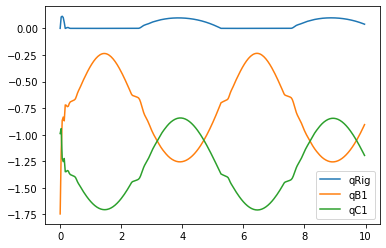

In [42]:
# States:

plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qRig','qB1','qC1'])

2022-05-01 04:00:25,114 - pynamics.output - INFO - calculating outputs
2022-05-01 04:00:25,390 - pynamics.output - INFO - done calculating outputs


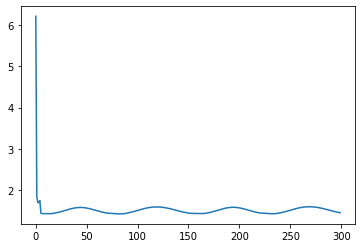

In [43]:
# Energy:

KE = system.get_KE()
PE = system.getPEGravity(pRigA1) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

Note that the total energy  of the system does not purely decay over time because the sinusoidal input torques add energy to the system.

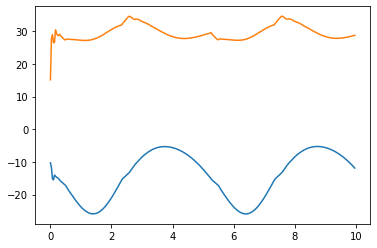

In [44]:
# Constraint Forces:

if use_constraints:
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)

2022-05-01 04:00:35,930 - pynamics.output - INFO - calculating outputs
2022-05-01 04:00:36,179 - pynamics.output - INFO - done calculating outputs


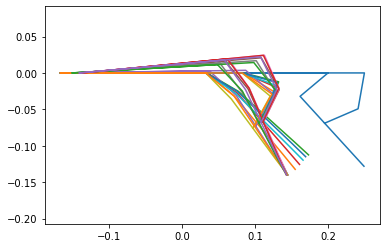

In [45]:
# Motion:

points = points = [pC1B2,pB1C1,pA1B1,pRigA1,pRigA2,pO,pRigA1,pRigA2,pA2B2,pB2C1,pC1A31,pA31A32]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

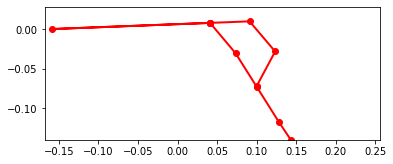

In [46]:
# Motion Animation:

points_output.animate(fps = fps,movie_name = 'triple_pendulum.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

## Bibliography:

[1] J. Kim, K. A. Kazmierczak, and G. J. Breur, “Comparison of temporospatial and kinetic variables of walking in small and large dogs on a pressure-sensing walkway,” *American Journal of Veterinary Research*, vol. 72, no. 9, pp. 1171–1177, 2011. 